In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sklearnm
import random as rnd
import math

In [2]:
data = pd.read_csv("skripsifull.csv")
data = data.select_dtypes(exclude=['object','bool'])

In [3]:
datautuh=data

In [4]:
# menormalisasi dataset
normalizeData = (data - data.min()) / (data.max() - data.min())
normalizeData = normalizeData.fillna(0)

In [5]:
data = (normalizeData.values.tolist())

# PSO

In [6]:
#inisialisasi pso
jml_cluster = 3 # Nc
jml_partikel = 100 
intbobot = [0.4, 0.9]  # i
c1=1.49
c2=1.49
intkecepatan = [-0.005, 0.005]  # v
jml_iterasi = 200 # iter_max
r1 = rnd.random()
r2 = rnd.random()
fitur = len(data[0])

In [7]:
partikel = [[] for j in range(jml_partikel)]
x = [k for k in range(len(data))]
rnd.shuffle(x)
for i in range(jml_partikel):
    for j in range(jml_cluster):
        y = x[j]
        partikel[i].append(data[y])
        
def hitungJarakPSO(partikel):
    jarak = [ [[] for i in range(jml_cluster)] for j in range(jml_partikel)]
    for p in range (jml_partikel):
        for x in range (jml_cluster) :
            for y in range (len(data)) :
                temp=0
                for z in range (len(data[1])) :
                    temp += (partikel[p][x][z]-data[y][z])**2
                temp = math.sqrt(temp)
                jarak[p][x].append(temp)
    return jarak


def minclusPSO(jarak):
    mymin=[[] for p in range(jml_partikel)]
    for i in range (jml_partikel):
        jarak[i] = [list(j) for j in zip(*jarak[i])]
        for x in jarak[i] :
            mymin[i].append(min(x))
    return mymin

def pengelompokanPSO(jarak,mymin): #menentukan cluster
    c=[[] for p in range(jml_partikel)]
    for i in range (jml_partikel):
        #jarak[i] = [list(j) for j in zip(*jarak[i])]
        for x in (range(len(jarak[i]))):
            for y in range (jml_cluster):
                if (jarak[i][x][y]== mymin[i][x]) :
                    c[i].append(y+1)
    return c


def rataratacluster(cluster,jarak): #mencari nilai fitness
    fitness=[]
    ratarata=[[] for i in range(jml_partikel)]

    for x in range(jml_partikel):
        jarak[x] = [list(j) for j in zip(*jarak[x])] 
        temp=0
        for y in range (jml_cluster):
            k=0
            tempp=0
            for z in range(len(data)):
                if(cluster[x][z]==(y+1)):
                    tempp += jarak[x][y][z]
                    k+=1
            if (k!=0):
                ratarata[x].append(tempp/k)
            else:
                ratarata[x].append(0)
            temp+=ratarata[x][y]
        fitness.append(temp/jml_cluster)
    return (fitness)

def partikelgbest(fitness,pbest):
    gbest=min(fitness)
    #print(gbest)
    for i in range(jml_partikel):
        if(gbest==fitness[i]):
            pgbest=pbest[i]
    return pgbest

### iterasi-0 ###
jarakPSO = hitungJarakPSO(partikel)
#print(jarakPSO)
myminPSO = minclusPSO(jarakPSO)
#print(myminPSO)
clusterbaruPSO = pengelompokanPSO(jarakPSO,myminPSO)
#print(clusterbaruPSO)
fitness=rataratacluster(clusterbaruPSO,jarakPSO)

#inisialisasi kecepatan awal
kecepatan=[ [[] for i in range(jml_cluster)] for j in range(jml_partikel)]
for x in range(jml_partikel):
    for y in range(jml_cluster):
        for z in range(fitur):
            kecepatan[x][y].append(rnd.random())
pbest=partikel
gbest=partikelgbest(fitness,pbest)

def updatekecepatan(w,kecepatan,pbest,partikel,gbest):
    for x in range(jml_partikel):
        for y in range(jml_cluster):
            for z in range(fitur):
                temp=(w*kecepatan[x][y][z])+(c1*r1*(pbest[x][y][z]-partikel[x][y][z]))+(c2*r2*(gbest[y][z]-partikel[x][y][z]))
                if (temp<=intkecepatan[0]):
                    kecepatan[x][y][z]=intkecepatan[0]
                elif (temp>=intkecepatan[1]):
                    kecepatan[x][y][z]=intkecepatan[1]
                else:
                    kecepatan[x][y][z]=temp
    return(kecepatan)

def updateposisi(partikel,kecepatan):
    partikelnew=[ [[] for i in range(jml_cluster)] for j in range(jml_partikel)]
    for x in range(jml_partikel):
        for y in range(jml_cluster):
            for z in range(fitur):
                if((partikel[x][y][z]+kecepatan[x][y][z])<=0):
                    partikelnew[x][y].append(0)
                elif((partikel[x][y][z]+kecepatan[x][y][z])>=1):
                    partikelnew[x][y].append(1)
                else:
                    partikelnew[x][y].append(partikel[x][y][z]+kecepatan[x][y][z])
    return(partikelnew)

def cekfitness(fitness,fitnessnew):
    minfitness=[]
    for i in range(len(fitness)):
        minfitness.append(min(fitness[i],fitnessnew[i]))
    return (minfitness)
def updatepbest(fitnessnew,minfitness,partikel,pbest):
    for x in range(jml_partikel):
        for y in range(jml_cluster):
            for z in range(fitur):
                if(minfitness[x]==fitnessnew[x]):
                    pbest[x]=partikel[x]
    return (pbest)

### iterasi-n ###
for i in range(jml_iterasi):
    w=(intbobot[1]-((intbobot[1]-intbobot[0])/jml_iterasi)*(i+1))
    kecepatan = updatekecepatan(w,kecepatan,pbest,partikel,gbest)
    partikel = updateposisi(partikel,kecepatan)
    jarakPSO = hitungJarakPSO(partikel)
    myminPSO = minclusPSO(jarakPSO)
    clusterPSO = pengelompokanPSO(jarakPSO,myminPSO)
    fitnessnew=rataratacluster(clusterPSO,jarakPSO)
    minfitness=cekfitness(fitness,fitnessnew)
    pbest=updatepbest(fitnessnew,minfitness,partikel,pbest)
    gbest=partikelgbest(minfitness,pbest)
    fitness=minfitness

# K-Means

In [8]:
#inisialisasi kmeans
maxLoops = 100
centroid=gbest

In [9]:
# Perhitungan jarak pusat cluster dengan rumus euclidean distance
def minclus(jarak):
    mymin = []
    jarak = [list(i) for i in zip(*jarak)]
    for x in jarak:
        mymin.append(min(x))
    return mymin

def hitungJarak(centroid):
    c = [[] for i in range(jml_cluster)]
    for x in range(jml_cluster):
        for y in range(len(data)):
            temp = 0
            for z in range(len(data[1])):
                temp += (centroid[x][z] - data[y][z]) ** 2
            temp = math.sqrt(temp)
            c[x].append(temp)
    return c

def pengelompokan(jarak, mymin):  # menentukan cluster
    c = []
    jarak = [list(i) for i in zip(*jarak)]
    for x in (range(len(jarak))):
        for y in range(jml_cluster):
            if (jarak[x][y] == mymin[x]):
                c.append(y + 1)
                break;
    return c

def pusatCluster(cluster): #mengupdate pusat cluster
    centroid=[[] for i in range(jml_cluster)]
    for x in range(fitur):
        for y in range(jml_cluster):
            k=0
            temp=0
            for z in range(len(data)):
                if (cluster[z]==(y+1)):
                    temp+=data[z][x]
                    k+=1
            if (k!=0):
                centroid[y].append(temp/k)
            else:
                centroid[y].append(0)
    return centroid

def cekIterasi(clusterlama,clusterbaru,i):
    x=0
    for z in range(len(clusterbaru)):
        if(clusterlama[z] != clusterbaru[z]):
            x+=1
    if (x==0):
        i+=maxLoops
    return i

In [10]:
#melakukan iterasi
clusterlama=[]
for x in range(len(data)):
    clusterlama.append(0)
i=0
while(i<=maxLoops):
    i+=1
    #print('iterasi ke -',(i))
    jarak = hitungJarak(centroid)
    mymin = minclus(jarak)
    clusterbaru = pengelompokan(jarak,mymin)
    i = cekIterasi(clusterlama,clusterbaru,i)
    clusterlama = clusterbaru
    centroid.clear()
    centroid = pusatCluster(clusterbaru)
    datautuh['cluster']=clusterbaru
print(datautuh)

     APM SD  APM SMP  APM SMA   APS7  APS13  APS16  APK SD  APK SMP  APK SMA  \
0     99.19    89.57    80.51  99.44  97.84  88.29  111.91    94.34   101.53   
1     99.70    86.16    67.72  99.97  97.51  84.17  109.02    95.20    81.53   
2     99.41    86.88    75.28  99.41  98.36  83.68  109.54    96.09   128.68   
3     99.36    90.03    69.27  99.66  98.53  83.71  109.54   101.24    83.26   
4     98.83    85.79    59.55  99.75  97.80  73.83  110.65    99.74    78.61   
..      ...      ...      ...    ...    ...    ...     ...      ...      ...   
509   52.22    26.95    11.59  52.22  32.43  22.55   78.75    96.83    44.55   
510   85.03    68.44    36.69  85.88  83.44  65.16  104.16    60.72    28.83   
511   61.45    15.94    10.73  61.45  52.79  38.80  120.38    73.70   100.60   
512   62.76    49.45    40.39  65.82  60.05  53.25   88.00    53.66    10.56   
513   95.30    78.50    67.46  97.15  98.07  92.21   94.11   106.10    73.35   

     cluster  
0          2  
1        

In [11]:
datautuh_1=pd.DataFrame(datautuh)
datautuh_1

,APM SD,APM SMP,APM SMA,APS7,APS13,APS16,APK SD,APK SMP,APK SMA,cluster
0,99.19,89.57,80.51,99.44,97.84,88.29,111.91,94.34,101.53,2
1,99.70,86.16,67.72,99.97,97.51,84.17,109.02,95.20,81.53,2
2,99.41,86.88,75.28,99.41,98.36,83.68,109.54,96.09,128.68,2
3,99.36,90.03,69.27,99.66,98.53,83.71,109.54,101.24,83.26,2
4,98.83,85.79,59.55,99.75,97.80,73.83,110.65,99.74,78.61,2
...,...,...,...,...,...,...,...,...,...,...
509,52.22,26.95,11.59,52.22,32.43,22.55,78.75,96.83,44.55,3
510,85.03,68.44,36.69,85.88,83.44,65.16,104.16,60.72,28.83,3
511,61.45,15.94,10.73,61.45,52.79,38.80,120.38,73.70,100.60,3
512,62.76,49.45,40.39,65.82,60.05,53.25,88.00,53.66,10.56,3


# Silhouette Coefficient

In [12]:
#menghitung Silhouette Coefficient
#euclidean tiap data
euc = [ [] for i in range(len(data))]
for x in range (len(data)) : 
    for y in range (len(data)) : 
        temp=0
        for z in range (len(data[1])) : 
            temp += (data[x][z]-data[y][z])**2
        temp = math.sqrt(temp)
        euc[x].append(temp)

#perhitungan ai
print(clusterbaru)
ai=[]
for x in range (len(clusterbaru)) : 
    temp=0
    n=0
    for y in range(len(clusterbaru)) : 
        if (clusterbaru[x]==clusterbaru[y]):
            temp+=euc[x][y]
            n+=1
    ai.append(temp/n)

#perhitungan bi
d=[ [] for i in range(len(data))]
bi=[]

for x in range (len(clusterbaru)) : 
    for y in range(jml_cluster) :
        temp=0
        n=0
        for z in range(len(clusterbaru)) : 
            if ((y+1)!=clusterbaru[x]):
                if(clusterbaru[z]==(y+1)):
                    #print('euc',euc[x][j])
                    temp+=euc[x][z]
                    n+=1
        if(temp!=0):
            d[x].append(temp/n)
    bi.append(min(d[x]))

#perhitungan si
si=[]
maxab=[]
sigsi=0
for x in range(len(ai)):
    maxab.append(max(ai[x],bi[x]))
    si.append((bi[x]-ai[x])/maxab[x])
    sigsi+=si[x]
sigsi=(sigsi/len(si))
print(sigsi)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 

# Visualisasi

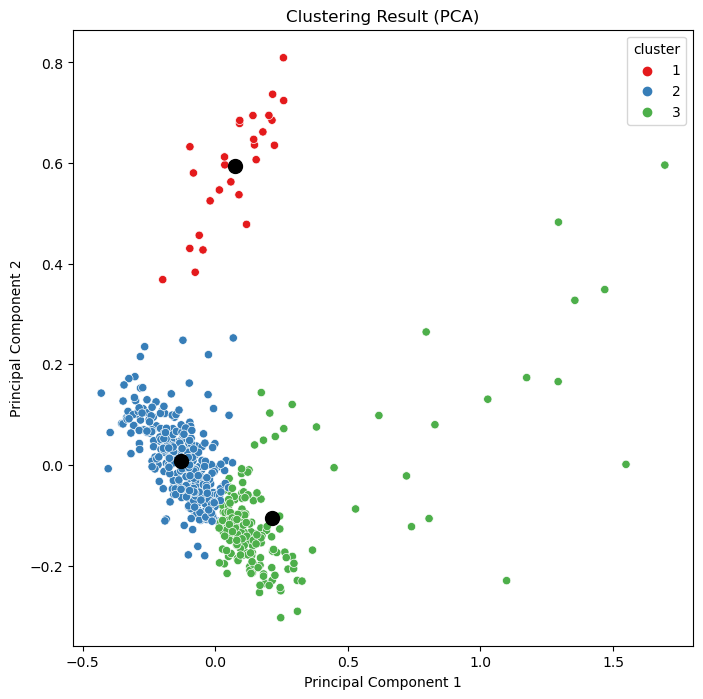

In [13]:
from sklearn.decomposition import PCA

# Menerapkan PCA dengan 2 komponen
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Membuat DataFrame baru untuk data hasil PCA
data_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
data_pca['cluster'] = clusterbaru
centroid_reduced = pca.transform(centroid)

# Memplot data hasil PCA
plt.figure(figsize=(8, 8))
sns.scatterplot(data=data_pca, x='PC1', y='PC2', hue='cluster', palette='Set1')
plt.scatter(centroid_reduced[:, 0], centroid_reduced[:, 1], color='black', s=100)
plt.title('Clustering Result (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [14]:
# Menghitung banyak instansi dalam klaster 1
cluster_1 = 1  # Nomor klaster yang ingin dihitung
banyak_cluster_1 = np.bincount(clusterbaru)[cluster_1]
print("Banyak Cluster 1:", banyak_cluster_1)

Banyak Cluster 1: 27


In [15]:
# Menghitung banyak instansi dalam klaster 2
cluster_2 = 2  # Nomor klaster yang ingin dihitung
banyak_cluster_2 = np.bincount(clusterbaru)[cluster_2]
print("Banyak Cluster 2:", banyak_cluster_2)

Banyak Cluster 2: 310


In [16]:
# Menghitung banyak instansi dalam klaster 3
cluster_3 = 3  # Nomor klaster yang ingin dihitung
banyak_cluster_3 = np.bincount(clusterbaru)[cluster_3]
print("Banyak Cluster 3:", banyak_cluster_3)

Banyak Cluster 3: 177
